# Modelos de Scoring para Riesgo de Crédito


Esta aplicación incorpora el proceso completo de creación de un modelo de scoring de crédito, incluyendo la estimación de la Probabilidad de Incumplimiento (PD), la Pérdida dado el Incumplimiento (LGD), la Exposición (EAD) y la Pérdida Esperada (EL). EL objetivo es construir un sistema para evaluar el riesgo de nuevos solicitantes de crédito y calcular la pérdida potencial para la institución financiera.

En esta aplicación usaremos un dataset de LendingClub disponible en Kaggle, que contiene información sobre préstamos emitidos, su estado actual y características del prestatario. Puedes descargarlo desde aquí: [Lending Club Loan Data en Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club).

Conceto clave:
* Probabilidad de incumplimiento (PD): probabilidad de que un prestatario no pague un préstamo.
* Análisis exploratorio de datos (EDA): es la fase inicial de investigación del proceso de análisis de datos en la que se examinan los datos mediante métodos estadísticos y visualizaciones para comprender sus principales características, descubrir patrones y relaciones, e identificar anomalías o problemas de calidad de los datos. El EDA ayuda a orientar la selección de modelos estadísticos adecuados y garantizar que los datos sean lo suficientemente sólidos como para su posterior análisis e implementación de modelos.
* Peso de la evidencia (WoE) e Information Value (IV): ayuda a indetificar aquellas varibles que tienen un poder predictivo o relaciones fuertes con la probabilidad de incumplimiento.

El algoritmo completo incluye:

* Conexión y obtención de datos (Kaggle / subida manual).
* EDA y limpieza (missing, tipos, target).
* Feature engineering y tratamiento de fechas/ratios.
* Selección de variables (WoE e IV).
* Modelado PD (Logit), balanceo (con SMOTE / class_weight).
* Validación PD: AUC, ROC, accuracy, etc.
* Cálculo $EL: EL_i = PD_i \times LGD_i \times EAD_i$ — agregación por cartera y segmentación.


Paso 1: Configuración del Entorno y librerias
---
Primero, importamos todas las librerías necesarias para el análisis.

In [ ]:
# Instalar Kaggle
!pip install --q kaggle

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, brier_score_loss
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

Paso 1: Carga y Pre-procesamiento de Datos
---

Nota: Esta es la fase más crítica. La calidad de tu modelo depende directamente de la calidad de tus datos.

**1.1. Carga de Datos**

Cargamos el dataset y hacemos una primera inspección.

In [ ]:
# SI tienes los datos en un archivo .csv
# df = pd.read_csv('loans_data.csv')

In [ ]:
# Subir tu kaggle.json (lo descargas de tu perfil de Kaggle: Account > API > Create New Token):
from google.colab import files
files.upload()  # aquí seleccionas kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cazapata25","key":"3bce823a88c986d15cf24fe16ae5457b"}'}

In [ ]:
# Configurar .json a la carpeta de trabajo y dar permisos
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargar el dataset completo (datos accepted and rejected)
# URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club/data
!kaggle datasets download -d wordsforthewise/lending-club

Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 96% 1.21G/1.26G [00:15<00:01, 37.5MB/s]
100% 1.26G/1.26G [00:15<00:00, 88.1MB/s]


In [ ]:
# Descomprimir
!unzip lending-club.zip -d lending_club_data

Archive:  lending-club.zip
  inflating: lending_club_data/accepted_2007_to_2018Q4.csv.gz  
  inflating: lending_club_data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: lending_club_data/rejected_2007_to_2018Q4.csv.gz  
  inflating: lending_club_data/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [ ]:
#Listar los archivos disponibles -- verifica que los datos quedaron en la memoria virtual
!ls
!ls lending_club_data

kaggle.json  lending_club_data	lending-club.zip  sample_data
accepted_2007_to_2018q4.csv	rejected_2007_to_2018q4.csv
accepted_2007_to_2018Q4.csv.gz	rejected_2007_to_2018Q4.csv.gz


Como el dataset (dos archivos) son muy grandes; se recomienda trabajar sólo con un subset. Se puede usar nrows=XXXXX para cargar las primeras filas.

In [ ]:
# Se cargan por ej. los primeros 100_000 clientes
# Tambien se puede seleccionar una muestra de forma aleatoria: df.sample(n=100_000)
df = pd.read_csv("lending_club_data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv",
                       nrows=100_000, low_memory=False)
#df = df.sample(n=20_000)

In [ ]:
df.iloc[:3,:15]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified


In [ ]:
#df.to_excel("lending_data.xlsx")

In [ ]:
#pd.DataFrame(df['loan_status']).head(50)

In [ ]:
# Variables del dataset
df.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'po

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 115.2+ MB


**Lista de Variables**

1. **Características del Préstamo**

Son variables que describen los términos del propio préstamo.

'loan_status': Esta variable indica el estado actual del préstamo (Default/Non-Default)

'loan_amnt': Monto del préstamo. A mayor monto, mayor puede ser el riesgo.

'term': Plazo del préstamo (en meses). Préstamos a más largo plazo suelen tener mayor riesgo.

'int_rate': Tasa de interés. Una tasa más alta implica mayor riesgo.

'installment': Cuota mensual. Una cuota alta en relación con los ingresos del prestatario aumenta el riesgo.

'grade' y 'sub_grade': Calificación y subcalificación del préstamo asignada por LendingClub. Son fuertemente predictivas porque ya represnetan una evaluación de riesgo.

2. **Información del Prestatario**

Datos sobre la situación financiera y laboral del solicitante.

'annual_inc': Ingreso anual. A mayores ingresos, menor suele ser el riesgo de impago.

'home_ownership': Situación de la vivienda (alquiler, hipoteca, propia). Los propietarios con hipoteca o vivienda propia suelen considerarse menos riesgosos que los que alquilan.

'emp_length': Antigüedad laboral. Una mayor estabilidad laboral (más años en el mismo trabajo) se asocia con un menor riesgo.

'dti' (Debt-to-Income Ratio): Relación deuda-ingresos. Un DTI alto significa que una gran parte de los ingresos del prestatario ya está comprometida para pagar otras deudas.

'purpose': Propósito del préstamo (ej. consolidación de deuda, tarjeta de crédito, compra de coche). Algunos propósitos, como la consolidación de deudas, pueden estar asociados con un mayor riesgo.

3. **Historial de Crédito del Prestatario**

Variables que resumen el comportamiento crediticio pasado.

'fico_range_low' y 'fico_range_high': Puntuación FICO (Fair Isaac Corporation). Es uno de los predictores más fuertes del comportamiento crediticio futuro. La puntuación FICO es un número de tres dígitos que resume el historial de crédito.

'delinq_2yrs': Número de morosidades de más de 30 días en los últimos 2 años.

'inq_last_6mths': Número de consultas de crédito en los últimos 6 meses. Un número alto puede indicar estrés financiero.

'open_acc': Número de líneas de crédito abiertas.

'pub_rec': Número de registros públicos derogatorios (quiebras, sentencias, etc.).

'revol_util': Tasa de uso del crédito revolvente (cuánto crédito está usando en relación con el total disponible). Es una métrica que indica tu dependencia del crédito para financiar tu estilo de vida o gestionar tus finanzas. Una tasa alta es una señal de riesgo. El ejemplo más común es una tarjeta de crédito. Tienes un límite (ej. $5,000). Puedes gastar hasta ese límite, hacer un pago para liberar parte del crédito disponible y volver a gastar.

'total_acc': Número total de cuentas de crédito.

**Variables que Debes Excluir**

* Es crucial eliminar ciertas variables como "identificadores" para evitar problemas comunes en el modelado: id, member_id, url.

* También están las *variables con Fuga de Datos* (Data Leakage): Son variables que no estarían disponibles en el momento de decidir si se aprueba el préstamo. Su inclusión haría que tu modelo pareciera mucho más preciso de lo que realmente es. Ejemplos claros son: *out_prncp, total_pymnt, total_rec_prncp, total_rec_int, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt*. Todas estas se generan después de que el préstamo ha sido concedido y está en curso.


**1.1 Definición de la Variable Objetivo (Default)**
---
El riesgo de crédito se centra en predecir el incumplimiento. Crearemos una variable binaria (0 = No Incumplimiento, 1 = Incumplimiento) a partir de la columna loan_status

In [ ]:
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

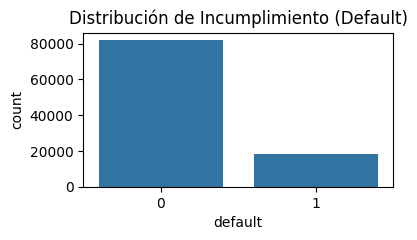

default
0    0.81955
1    0.18045
Name: proportion, dtype: float64


In [ ]:
# Estados que consideramos como 'Incumplimiento' (Default)
default_status = [
    'Charged Off',     # Cartera vencida o castigada
    'Default',         # Cesación de pagos
    'Does not meet the credit policy. Status:Charged Off',
    'Late (31-120 days)'  # Mora
]

#3 Esto significa que los creditos que no entraron en default son:
##non-default = ['Fully Paid', 'Current', 'In Grace Period','Late (16-30 days)']

# Creamos la variable objetivo 'default'
df['default'] = np.where(df['loan_status'].isin(default_status), 1, 0)

# Visualizamos la distribución
plt.figure(figsize=(4,2))
sns.countplot(x='default', data=df)
plt.title('Distribución de Incumplimiento (Default)')
plt.show();
print(df['default'].value_counts(normalize=True))

**1.2. Limpieza y definición de Variables**
Muchas columnas necesitan ser convertidas a tipos de datos numéricos para poder usarlas en el modelo.

In [ ]:
# Identificamos una lista potencial de variables claves, antes de su tratamiento:
features = [ 'default','loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc',
    'dti', 'fico_range_low', 'open_acc', 'pub_rec', 'revol_util', 'delinq_2yrs',
    'total_acc', 'emp_length', 'home_ownership', 'grade',  'total_rec_prncp']
df = df[features]
#df.describe()

In [ ]:
# Convertir porcentajes a poporciones
df['int_rate'] = df['int_rate'] / 100
df['revol_util'] = df['revol_util'] / 100
df['dti'] = df['dti'] / 100

# Crear Ratios
# Ratio: Monto del Préstamo / Ingreso Anual: loan_amnt/annual_inc
df['loan_income'] = df['loan_amnt'] / df['annual_inc']
# Ajusta el valor min-max para evitar errores
df['loan_income'] = np.clip(df['loan_income'], 0.0001, 0.9999)

# Ratio: Cuota Mensual / Ingreso Mensual: installment / (annual_inc / 12)
df['credit_installment'] = df['installment'] / (df['annual_inc'] / 12)
# Ajusta el valor min-max para evitar errores
df['credit_installment'] = np.clip(df['credit_installment'], 0.0001, 0.9999)

# Ratio Frecuencia de Morosidad: delinq_2yrs / total_acc
#df['delinquency'] = df['delinq_2yrs'] / df['total_acc']

# Convertir años de empleo a valor numerico
# Mapeamos '10+ years' a 10, '< 1 year' a 0, y extraemos el numero para los demas.
df['emp_length'] = df['emp_length'].str.replace(' years', '').str.replace(' year', '').str.replace('< 1', '0.5').str.replace('10\+', '10')
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')

# Manejo de valores nulos | opcion 1: rellenar con la mediana (estrategia simple) / opcion 2: rellenar con ceros (0)
for col in ['emp_length', 'revol_util', 'annual_inc','dti','delinq_2yrs']:
    df[col].fillna(df[col].median(), inplace=True)

In [ ]:
df.head(3)

,default,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,open_acc,pub_rec,revol_util,delinq_2yrs,total_acc,emp_length,home_ownership,grade,total_rec_prncp,loan_income,credit_installment
0,0,3600.0,3600.0,0.1399,123.03,55000.0,0.0591,675.0,7.0,0.0,0.297,0.0,13.0,3.0,MORTGAGE,C,3600.0,0.065455,0.026843
1,0,24700.0,24700.0,0.1199,820.28,65000.0,0.1606,715.0,22.0,0.0,0.192,1.0,38.0,3.0,MORTGAGE,C,24700.0,0.380000,0.151436
2,0,20000.0,20000.0,0.1078,432.66,63000.0,0.1078,695.0,6.0,0.0,0.562,0.0,18.0,3.0,MORTGAGE,B,20000.0,0.317460,0.082411


Paso 2. Selección de Variables Clave usando WoE-IV
---

Para modelos de scoring, una técnica estándar es usar el Valor de la Información (Information Value - IV) basado en el WoE. El IV mide la capacidad predictiva de una variable para separar los casos "buenos" (no default) de los "malos" (default).

Reglas generales para IV:

* < 0.02: No predictiva
* 0.02 - 0.1: Débilmente predictiva
* 0.1 - 0.3: Medianamente predictiva
* 0.3 - 0.5: Fuertemente predictiva
* mayor a 0.5: Sospechosamente alta (podría haber data leakage)

Implementamos una función para calcular el IV:

In [ ]:
def calculate_iv(df, feature, target):
    # Agrupamos la variable en 10 cuantiles
    df[feature + '_bin'] = pd.qcut(df[feature], q=10, duplicates='drop')
    grouped = df.groupby(feature + '_bin')[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped = grouped.loc[grouped['sum'] > 0 & (grouped['non_event'] > 0)]

    # % de eventos (malos) y no eventos (buenos) por clase o grupo
    grouped['dist_event'] = grouped['sum'] / df[target].sum()
    grouped['dist_non_event'] = grouped['non_event'] / (df[target].count() - df[target].sum())

    # Weight of Evidence (WoE)
    grouped['woe'] = np.log(grouped['dist_non_event'] / grouped['dist_event'])

    # Information Value (IV)
    grouped['iv'] = (grouped['dist_non_event'] - grouped['dist_event']) * grouped['woe']
    return grouped['iv'].sum()

In [ ]:
features = ['default', 'int_rate', 'revol_util', 'loan_income', 'credit_installment', 'delinq_2yrs',
           'emp_length', 'dti', 'fico_range_low', 'pub_rec', 'loan_amnt', 'annual_inc']
datos = df[features]
#features = ['int_rate', 'revol_util', 'loan_income', 'credit_installment', 'delinq_2yrs',
#           'emp_length', 'dti', 'fico_range_low', 'pub_rec','loan_amnt', 'annual_inc']

iv_scores = {}
for feature in features:
    iv_scores[feature] = calculate_iv(datos, feature, target='default')

iv_df = pd.DataFrame.from_dict(iv_scores, orient='index', columns=['IV'])
iv_df.sort_values(by='IV', ascending=False, inplace=True)
print("Information Value de las variables:")
iv_df

Information Value de las variables:


,IV
int_rate,0.481286
fico_range_low,0.128857
loan_income,0.078579
credit_installment,0.075631
dti,0.064609
annual_inc,0.033934
loan_amnt,0.015969
revol_util,0.009216
delinq_2yrs,0.001375
pub_rec,0.001211


In [ ]:
# Seleccionamos variables con IV > 0.x - Ej. IV > 0.02
selected_features = iv_df[iv_df['IV'] > 0.015].index.tolist()
print("\nVariables seleccionadas para el modelo PD:", selected_features)


Variables seleccionadas para el modelo PD: ['int_rate', 'fico_range_low', 'loan_income', 'credit_installment', 'dti', 'annual_inc', 'loan_amnt']


In [ ]:
# Actualizamos el dataset con las variables seleccionadas usando el IV
datos = df[selected_features]
datos['home_ownership'] = df['home_ownership']
datos['grade'] = df['grade']
datos['default'] = df['default']
datos.head(3)

,int_rate,fico_range_low,loan_income,credit_installment,dti,annual_inc,loan_amnt,home_ownership,grade,default
0,0.1399,675.0,0.065455,0.026843,0.0591,55000.0,3600.0,MORTGAGE,C,0
1,0.1199,715.0,0.380000,0.151436,0.1606,65000.0,24700.0,MORTGAGE,C,0
2,0.1078,695.0,0.317460,0.082411,0.1078,63000.0,20000.0,MORTGAGE,B,0


El resultado de esta tabla nos muestra qué variables tienen mayor poder para discriminar entre un buen y mal pagador o sujeto de crédito (estás variables suelen ser las más importantes)

# Variables categoricas

In [ ]:
# Convertir variables categóricas a dummies"
datos_dummies = pd.get_dummies(datos, columns=['home_ownership','grade'], drop_first=True)
print("Columnas después de la codificación one-hot:")
print(datos_dummies.columns)

Columnas después de la codificación one-hot:
Index(['int_rate', 'fico_range_low', 'loan_income', 'credit_installment',
       'dti', 'annual_inc', 'loan_amnt', 'default', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G'],
      dtype='object')


In [ ]:
datos_dummies.head(3)

,int_rate,fico_range_low,loan_income,credit_installment,dti,annual_inc,loan_amnt,default,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0.1399,675.0,0.065455,0.026843,0.0591,55000.0,3600.0,0,True,False,False,False,True,False,False,False,False
1,0.1199,715.0,0.380000,0.151436,0.1606,65000.0,24700.0,0,True,False,False,False,True,False,False,False,False
2,0.1078,695.0,0.317460,0.082411,0.1078,63000.0,20000.0,0,True,False,False,True,False,False,False,False,False


Paso 3: Estimación de la Probabilidad de Incumplimiento (PD)
---
Usaremos un modelo de Regresión Logística, que es el estándar en la industria por su interpretabilidad y robustez.

**3.1. Preparación de Datos y División (Train/Test)**

Dividimos nuestro dataset para entrenar el modelo y luego validarlo con datos que no ha visto.

In [ ]:
# Definimos las variables independientes (predictivas) y dependiente
X = datos_dummies.drop('default', axis=1)
y = datos_dummies['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # Usar el scaler ajustado en train

print(f"Tamaño de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño de prueba: {X_test.shape[0]}")

Tamaño de entrenamiento: 80000
Tamaño de prueba: 20000


**3.2. Entrenamiento del Modelo de PD**

In [ ]:
pd_model = LogisticRegression(class_weight='balanced',random_state=42)  # class_weight='balanced', 'auto'
pd_model.fit(X_train, y_train)
# Obtenemos las probabilidades de incumplimiento para el set de prueba
y_pred = pd_model.predict(X_test)
y_pred_proba = pd_model.predict_proba(X_test)[:, 1]

**3.3. Validación del Modelo de PD**


Accuracy Score:  0.62
Matriz de Confusión:


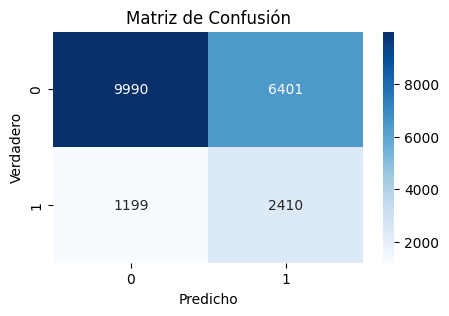

In [ ]:
# Métricas de evaluación
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
print("Reporte de Clasificación: ")
print(classification_report(y_test, y_pred))
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       0.89      0.61      0.72     16391
           1       0.27      0.67      0.39      3609

    accuracy                           0.62     20000
   macro avg       0.58      0.64      0.56     20000
weighted avg       0.78      0.62      0.66     20000



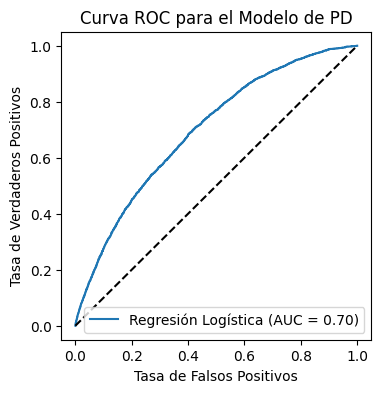

In [ ]:
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'Regresión Logística (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para el Modelo de PD')
plt.legend()
plt.show()

**Entrenamiento y Evaluación del Modelo con SMOTE**

In [ ]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Distribución de clases después de SMOTE: ")
print(y_train_smote.value_counts())

Distribución de clases después de SMOTE: 
default
1    65564
0    65564
Name: count, dtype: int64


In [ ]:
# Entrenar el modelo con los datos balanceados
pd_model_balanced = LogisticRegression(random_state=42)
pd_model_balanced.fit(X_train_smote, y_train_smote)

# Obtenemos las probabilidades de incumplimiento para el set de prueba
y_pred_balanced = pd_model_balanced.predict(X_test)
y_pred_proba = pd_model_balanced.predict_proba(X_test)[:, 1]

In [ ]:
print("Evaluación del Modelo Mejorado (con SMOTE)")
print("Accuracy Score: ", accuracy_score(y_test, y_pred_balanced))
print("Reporte de Clasificación: ")
print(classification_report(y_test, y_pred_balanced))

Evaluación del Modelo Mejorado (con SMOTE)
Accuracy Score:  0.6225
Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       0.89      0.61      0.73     16391
           1       0.27      0.66      0.39      3609

    accuracy                           0.62     20000
   macro avg       0.58      0.64      0.56     20000
weighted avg       0.78      0.62      0.67     20000



Matriz de Confusión: 


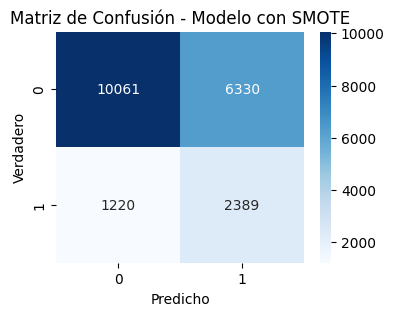

In [ ]:
print("Matriz de Confusión: ")
cm = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Modelo con SMOTE')
plt.show();

**Selección del modelo**

¿Cuál es el mejor modelo?


## Paso 4: Cálculo de la Pérdida Esperada (Expected Loss - EL)
La Pérdida Esperada es el pilar de la gestión de riesgo y provisiones. Se calcula con la famosa fórmula:

$$ EL=PD \times LGD \times EAD $$

* PD (Probability of Default): La probabilidad de que un cliente incumpla. (La obtuvimos del modelo de Regresión Logística).

* LGD (Loss Given Default): La pérdida si el cliente incumple. (La obtuvimos del modelo de Regresión Forestal).

* EAD (Exposure at Default): El monto adeudado en el momento del incumplimiento. Para simplificar, usaremos el monto original del préstamo (funded_amnt).

**4.1. Modelación de la Severidad (Loss Given Default - LGD)**

LGD es el porcentaje de la exposición que se pierde si el cliente incumple. Se modela únicamente sobre los préstamos que ya han entrado en default.

*LGD = 1 - Tasa de Recuperación = 1 - (Monto Recuperado / Monto del Préstamo)*

In [ ]:
df.head(3)

,default,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,open_acc,pub_rec,revol_util,delinq_2yrs,total_acc,emp_length,home_ownership,grade,total_rec_prncp,loan_income,credit_installment
0,0,3600.0,3600.0,0.1399,123.03,55000.0,0.0591,675.0,7.0,0.0,0.297,0.0,13.0,3.0,MORTGAGE,C,3600.0,0.065455,0.026843
1,0,24700.0,24700.0,0.1199,820.28,65000.0,0.1606,715.0,22.0,0.0,0.192,1.0,38.0,3.0,MORTGAGE,C,24700.0,0.380000,0.151436
2,0,20000.0,20000.0,0.1078,432.66,63000.0,0.1078,695.0,6.0,0.0,0.562,0.0,18.0,3.0,MORTGAGE,B,20000.0,0.317460,0.082411


In [ ]:
#-------------------------------------------------
# Filtramos solo los préstamos en default
#df = datos_dummies
df_defaulted = df[df['default'] == 1].copy()
df_defaulted['total_rec_prncp'] = df['total_rec_prncp']
df_defaulted['funded_amnt'] = df['funded_amnt']

# Calculamos la tasa de recuperación
df_defaulted['recovery_rate'] = df_defaulted['total_rec_prncp'] / df_defaulted['funded_amnt']
df_defaulted['recovery_rate'] = np.clip(df_defaulted['recovery_rate'], 0, 1) # Aseguramos que esté entre 0 y 1
# Calculamos LGD
df_defaulted['lgd'] = 1 - df_defaulted['recovery_rate']

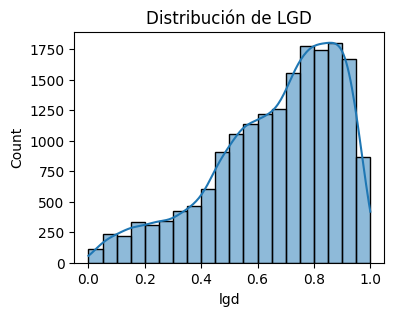

In [ ]:
# Distribucion de la Severidad: LGD
plt.figure(figsize=(4, 3))
sns.histplot(df_defaulted['lgd'], bins=20, kde=True)
plt.title('Distribución de LGD')
plt.show()

In [ ]:
df_defaulted['lgd'].describe()

,lgd
count,18045.000000
mean,0.665163
std,0.225109
min,0.000000
25%,0.529174
50%,0.713334
75%,0.844676
max,1.000000



**Si queremos definir un LGD fijo en el modelo**:


In [ ]:
df_defaulted['lgd'].mean()

np.float64(0.6651629204257336)

**También podemos estimar un modelo de LGD propio para el dataset**

El LGD es una variable continua, por lo que puede usarse un modelo de regresión o se pueden tomar las recomendaciones regulatorias o historiales de la entidad.


Modelar LGD es complejo. Un R-cuadrado bajo es común. A menudo, las empresas optan por usar promedios de LGD segmentados por tipo de producto o cliente en lugar de modelos predictivos individuales.

**4.2. Cálculo de EL a Nivel Individual**

Ahora aplicamos nuestras predicciones al conjunto de prueba para calcular la EL de cada préstamo.

In [ ]:
# I. Preparamos el dataframe de prueba con todas las variables necesarias
X = datos_dummies.drop('default', axis=1)
y = datos_dummies['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

test_df = df.loc[X_test.index].copy()
test_df['default_actual'] = y_test
test_df['funded_amnt'] = df.loc[test_df.index, 'funded_amnt'] # Añadimos EAD: Exposicion

In [ ]:
# II. Predecir la PD
# Esgogemos el primer modelo: Regresion Logistica con class_weight='balanced',
test_df['pd'] = y_pred_proba  # pd_model.predict_proba(X_test)[:, 1]
test_df['pd'].head(3)

,pd
5419,0.572480
22919,0.151051
42917,0.101435


In [ ]:
# III. LGD (usando las variables relevantes para LGD)
# Nota: Para préstamos que no incumplen, el LGD no aplica, pero para el cálculo de EL *ex-ante*
# se estima un LGD para todos.
lgd = 0.2 * df_defaulted['lgd'].mean()
test_df['lgd'] = lgd

In [ ]:
# IV. Definir EAD
test_df['ead'] = test_df['funded_amnt']

# V. Calcular EL
test_df['el'] = test_df['pd'] * test_df['lgd'] * test_df['ead']

print("Ejemplo de cálculo de EL para 5 préstamos:")
print(test_df[['funded_amnt', 'pd', 'lgd', 'el']].head())

Ejemplo de cálculo de EL para 5 préstamos:
       funded_amnt        pd       lgd           el
5419       10000.0  0.572480  0.133033   761.585276
22919      15000.0  0.151051  0.133033   301.420207
42917      25000.0  0.101435  0.133033   337.354248
39803      16000.0  0.593656  0.133033  1263.608991
15009      24000.0  0.216636  0.133033   691.670158


**4.3. Cálculo de EL para la Cartera de Créditos**
La pérdida esperada total de la cartera es simplemente la suma de las pérdidas esperadas individuales.

In [ ]:
el_cartera_total = test_df['el'].sum()
ead_cartera_total = test_df['ead'].sum()
el_porcentual_cartera = (el_cartera_total / ead_cartera_total) * 100

print(f"\nExposición Total al Incumplimiento (EAD) de la Cartera de Prueba: ${ead_cartera_total:,.2f}")
print(f"Pérdida Esperada (EL) Total de la Cartera de Prueba: ${el_cartera_total:,.2f}")
print(f"Pérdida Esperada como % del EAD Total: {el_porcentual_cartera:.2f}%")


Exposición Total al Incumplimiento (EAD) de la Cartera de Prueba: $301,021,450.00
Pérdida Esperada (EL) Total de la Cartera de Prueba: $18,733,826.90
Pérdida Esperada como % del EAD Total: 6.22%


## Otros modelos de Aprendizaje Automático (Machine Learning)



In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Árbol de decisión - Decission Tree
---
Un árbol de decisión es un modelo predictivo (no paramétrico) de aprendizaje supervisado que se utiliza tanto para clasificación como para regresión. El árbol divide recursivamente el espacio de las variables independientes en regiones homogéneas, según el valor de la variable objetivo (por ejemplo, default o no default). Su estructura es similar a la de un diagrama de flujo, donde cada "paso" prueba una característica de los datos, y el camino resultante lleva a una conclusión o predicción.

En clasificación crediticia, el árbol busca reglas del tipo: “Si la relación deuda/ingreso > 40% y el número de pagos atrasados > 2 → alto riesgo de incumplimiento.”

[Ingreso > 30.000]
├── Sí → [Deuda/Ingreso < 40%?]
│   ├── Sí → Riesgo Bajo (PD=0.05)
│   └── No  → Riesgo Medio (PD=0.15)
└── No → Riesgo Alto (PD=0.40)


Un árbol se compone de tres tipos principales de nodos:

* Nodo Raíz (Root Node): Es el punto de partida del árbol. Representa a toda la población de datos y es el primer nodo desde el cual se realiza la primera división (o "split").

* Nodos de Decisión (Decision Nodes / Internal Nodes): Son los nodos intermedios que surgen de una división. Cada uno representa una pregunta o una prueba sobre una característica específica. De cada nodo de decisión salen al menos dos ramas (branches).

* Nodos Hoja (Leaf Nodes / Terminal Nodes): Son los nodos finales del árbol. Ya no se dividen más. Cada hoja representa una decisión final o una clasificación. En un problema de clasificación (como predecir el incumplimiento), la hoja indicaría la clase predicha (ej. "Incumplimiento" o "No Incumplimiento"). En un problema de regresión, la hoja contendría el valor numérico predicho.

Para decidir cuál es la "mejor" pregunta o división en cada nodo, el algoritmo necesita una forma de medir la pureza o, más comúnmente, la impureza de los datos. El objetivo es que cada división haga que los grupos resultantes sean lo más homogéneos posible.

In [ ]:
# Inicializamos el clasificador.
# Usamos hiperparámetros de pre-poda para evitar el sobreajuste:
# - max_depth: Limita la profundidad del árbol.
# - min_samples_leaf: El número mínimo de muestras que debe tener una hoja.
# - class_weight='balanced': Ayuda a manejar el desbalance de clases (generalmente hay menos defaults).
tree_model = DecisionTreeClassifier( max_depth=4, min_samples_leaf=5,
    class_weight='balanced', random_state=42
)

# Entrenamos el modelo
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=5,
                       random_state=42)

In [ ]:
# Predicción de la Probabilidad de Incumplimiento (PD)
y_pred_tree = tree_model.predict(X_test)
y_pd_predictions = tree_model.predict_proba(X_test)[:, 1]

# Mostramos las predicciones para el conjunto de prueba.
results = pd.DataFrame({'Real_Status': y_test, 'Predicted_PD': y_pd_predictions})
print("Predicciones de Probabilidad de Incumplimiento (PD)")
print(results.head(5))

Predicciones de Probabilidad de Incumplimiento (PD)
       Real_Status  Predicted_PD
5419             0      0.525794
22919            0      0.107373
42917            0      0.107373
39803            0      0.586507
15009            0      0.301643


In [ ]:
# Evaluación del Modelo
auc_score = roc_auc_score(y_test, y_pred_tree)
print(f"\nEl rendimiento del modelo (AUC-ROC) es: {auc_score:.4f}")


El rendimiento del modelo (AUC-ROC) es: 0.6370


Matriz de Confusión: 


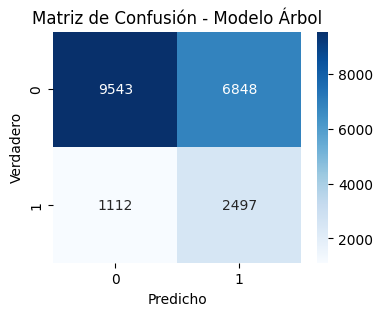

In [ ]:
print("Matriz de Confusión: ")
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Modelo Árbol')
plt.show();

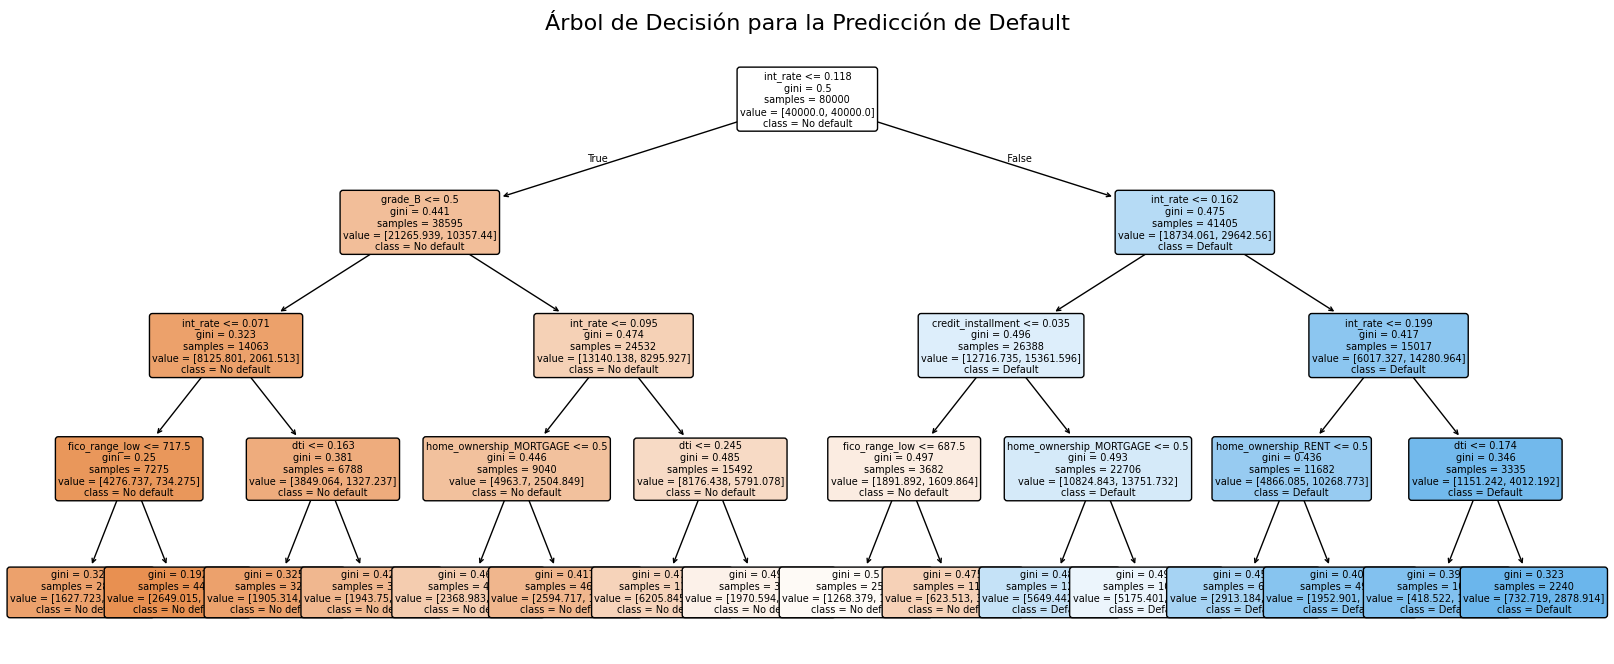

In [ ]:
#  Visualización del Árbol de Decisión
plt.figure(figsize=(20, 8))
plot_tree(
    tree_model,
    feature_names=X.columns,
    class_names=['No default', 'Default'],
    filled=True,
    rounded=True,
    fontsize=7
)
plt.title("Árbol de Decisión para la Predicción de Default", fontsize=16)
plt.show()

In [ ]:
# ----------

Random Forest y Gradient Boosting
---
Son dos de los algoritmos de machine learning más potentes y populares para problemas de clasificación como la estimación de la probabilidad de incumplimiento (PD). Ambos se basan en el concepto de modelos de ensamble (ensemble models), que combinan múltiples modelos más simples para obtener una predicción mucho más robusta y precisa.

Sin embargo, la forma en que construyen ese "equipo" de modelos es fundamentalmente diferente.

**Random Forest (Bosque Aleatorio)**

Construye una gran cantidad de árboles de decisión de forma independiente y luego promedia sus predicciones. En lugar de confiar en un solo experto (un solo árbol de decisión), generas cientos de expertos.

Paso 1: Bagging (Bootstrap Aggregating). El algoritmo crea múltiples subconjuntos de datos de tu set de entrenamiento original. Lo hace seleccionando filas al azar con reemplazo. Esto significa que algunas filas pueden aparecer varias veces en un subconjunto, mientras que otras pueden no aparecer en absoluto. Cada árbol del bosque se entrena con uno de estos subconjuntos.

Paso 2: Aleatoriedad de Características (Feature Randomness). Al construir cada árbol, cuando se tiene que decidir cómo dividir una rama (por ejemplo, ¿dividimos por ingreso_anual o por dti?), el algoritmo no considera todas las variables disponibles. En su lugar, selecciona un subconjunto aleatorio de variables y solo busca el mejor corte entre ellas.

Paso 3: Votación. Una vez que todos los árboles han sido entrenados, para predecir la probabilidad de incumplimiento de un nuevo cliente, se le pregunta a cada árbol del bosque. Si, por ejemplo, el 75% de los árboles votan "Incumplimiento" y el 25% votan "Paga", la probabilidad de incumplimiento predicha por el modelo es del 75%.

In [ ]:
# Modelo Random Forest
# - n_estimators: El número de árboles en el bosque (un hiperparámetro clave).
# - max_depth y min_samples_leaf: Siguen siendo útiles para controlar la complejidad de cada árbol individual.
# - class_weight='balanced': Muy importante para problemas de riesgo de crédito donde los 'defaults' son la clase minoritaria.
rf_model = RandomForestClassifier(
    n_estimators=100,      # Construimos un bosque con 100 árboles
    max_depth=5,           # Cada árbol no será demasiado profundo
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1              # Usar todos los procesadores disponibles para acelerar el entrenamiento
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Reporte - Random Forest")
print(classification_report(y_test, y_pred_rf))

Reporte - Random Forest
              precision    recall  f1-score   support

           0       0.90      0.58      0.71     16391
           1       0.27      0.70      0.39      3609

    accuracy                           0.60     20000
   macro avg       0.58      0.64      0.55     20000
weighted avg       0.78      0.60      0.65     20000



Matriz de Confusión: 


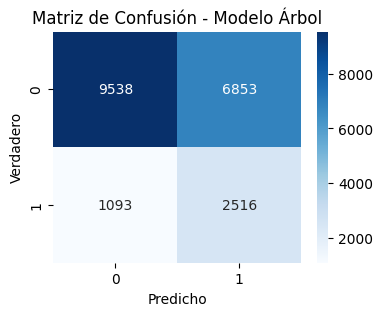

In [ ]:
print("Matriz de Confusión: ")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Modelo Árbol')
plt.show();

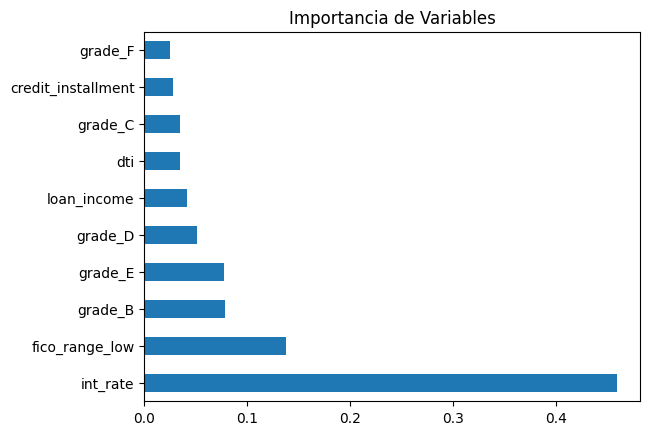

In [ ]:
# Importancia de variables
# Una de las grandes ventajas de Random Forest es que puede decirnos qué variables
# fueron las más importantes para tomar las decisiones.

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Importancia de Variables")
plt.show()

**Gradient Boosting**

Gradient Boosting también utiliza árboles de decisión, pero de una manera completamente diferente. En lugar de construir árboles independientes, los construye de forma secuencial, donde cada nuevo árbol intenta corregir los errores cometidos por el árbol anterior.

Paso 1: El Primer Intento. Se construye un primer árbol muy simple (a menudo llamado "weak learner" o aprendiz débil) que hace una predicción inicial. Esta predicción probablemente será bastante mala y tendrá grandes errores (residuos).

Paso 2: Aprender del Error. Se construye un segundo árbol. El objetivo de este nuevo árbol no es predecir la probabilidad de incumplimiento directamente, sino predecir los errores cometidos por el primer árbol.

Paso 3: Corregir y Repetir. La predicción del segundo árbol (que es una predicción del error) se suma a la predicción del primer árbol, mejorando el resultado general. Ahora, esta nueva predicción combinada todavía tiene errores. Entonces, se construye un tercer árbol para predecir estos nuevos errores, y así sucesivamente.

El "Gradiente": El término "gradiente" proviene del hecho de que el algoritmo utiliza una técnica de optimización matemática llamada descenso del gradiente para minimizar los errores en cada paso. Cada nuevo árbol se ajusta en la dirección que reduce más rápidamente el error general del modelo.

In [ ]:
# Inicializar el modelo (ej. con 100 árboles y una tasa de aprendizaje)
# - n_estimators: El número de árboles secuenciales que se construirán.
# - learning_rate: Controla cuánto contribuye cada árbol a la predicción final. Un valor más bajo requiere más árboles.
# - max_depth: Profundidad de cada árbol individual. Se suelen usar árboles poco profundos ("weak learners").
gb_model = GradientBoostingClassifier(
    n_estimators=100,      # Construimos 100 árboles en secuencia
    learning_rate=0.1,     # Cada árbol corrige el 10% del error restante
    max_depth=5,           # Árboles de decisión simples
    random_state=42
)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=42)

In [ ]:
pd_predictions_gb = gb_model.predict_proba(X_test)[:, 1]
y_pred_gb = gb_model.predict(X_test)
print("Reporte - Random Forest")
print(classification_report(y_test, y_pred_gb))

Reporte - Random Forest
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16391
           1       0.49      0.03      0.06      3609

    accuracy                           0.82     20000
   macro avg       0.66      0.51      0.48     20000
weighted avg       0.76      0.82      0.75     20000



In [ ]:
auc_gb = roc_auc_score(y_test, pd_predictions_gb)
print(f"AUC para Gradient Boosting: {auc_gb:.4f}")

AUC para Gradient Boosting: 0.6973



--- Matriz de Confusión ---


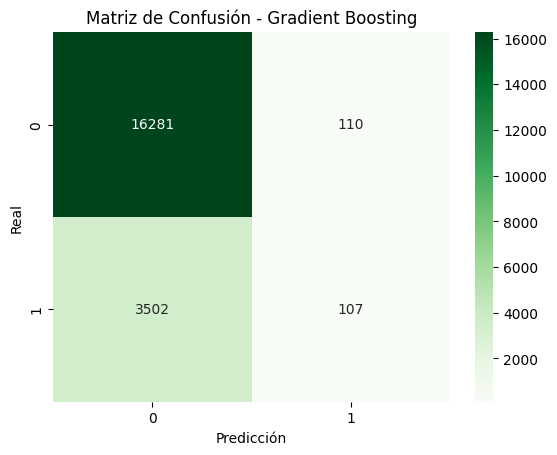

In [ ]:
print("\n--- Matriz de Confusión ---")
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()